In [1]:
### Jinrui Zhou
### MCB112 PSET11 - The Adventure of the 2001 Dimensions

In [2]:
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
use_log_dist = False

In [4]:
df = pd.read_table("w11-data.tbl.txt", delim_whitespace=True)
df

,arugula,blueberry,cabbage,chickpea,clementine,cranberry,honeydew,mulberry,mustard,onion,...,H2BFS,PDXK,C21orf33,PFKL,KRTAP10-8,SLC19A1,SLC19A1.1,AC136352.2,AC136352.2.1,AL592183.1
0,206,219,532,261,293,253,892,214,142,167,...,43,94,528,149,703,792,170,195,999,505
1,412,476,478,485,226,374,1315,765,135,269,...,108,126,815,173,1382,1141,188,221,480,413
2,206,621,895,267,607,133,1435,302,137,515,...,103,170,432,277,653,926,219,534,1115,470
3,95,565,1039,418,181,187,381,765,95,333,...,72,110,615,418,1017,456,184,234,2286,315
4,244,531,505,547,537,393,909,452,298,481,...,128,76,694,402,1257,288,363,141,1682,424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,348,352,682,819,489,259,1108,377,190,242,...,98,98,774,170,393,879,474,79,896,1003
196,211,278,584,878,632,149,824,229,85,199,...,34,74,370,624,1311,1037,410,195,820,557
197,70,384,470,957,557,108,1630,346,133,419,...,82,103,206,425,605,435,305,297,1919,1085
198,156,414,663,1001,316,271,1218,443,90,518,...,71,15,481,367,1236,659,299,232,1283,742


# 1. Reproduce Watsons's K-means Result
### Modify the K-means clustering procedure wrote for Wiggins' data so that it works in 2001 dimensions, not just 2. Run a reasonable number of iterations (20-100, or even better, test for convergence), starting from several different initializations; report the lowest total squared distance (best clustering) found for K=8. It should be close to what Watson found using k = 8 clusters, where his clustering achieved a sum of the squared distance = 87378.2. He used the "fixed" K-means method from part 3 of hw05, with his data represented as log counts.

In [5]:
def sample_component(X):
    dmin = np.amin(X, axis=0)
    dmax = np.amax(X, axis=0)
    N, G = np.shape(X)
    mu = np.zeros(G)
    for g in range(G):
        mu[g] = np.random.uniform(dmin[g], dmax[g])
    return mu

In [6]:
def euclidean_dist(V1, V2):
    D = 0
    for i in range(len(V1)):
        if use_log_dist:
            D += (np.log(V1[i]) - np.log(V2[i]))**2
        else:
            D += (V1[i] - V2[i])**2
    return np.sqrt(D)

In [7]:
def closest_centroid(x, centroids):
    K, dim = np.shape(centroids)
    best_k = 0
    best_dist = euclidean_dist(x, centroids[0])
    for k in range(1,K):
        dist = euclidean_dist(x, centroids[k])
        if dist < best_dist:
            best_k = k
            best_dist = dist
    return best_k, best_dist

In [8]:
def assign_kmeans(X, centroids):
    tot_sqdist  = 0
    N = len(X)
    assignments = np.zeros(N).astype(int)
    K, dim = np.shape(centroids)
    for i, x in enumerate(X):
        assignments[i], di = closest_centroid(x, centroids)
        tot_sqdist += di**2
    return assignments, tot_sqdist

In [9]:
def diff_assignments(a1, a2):
    diff = 0
    N = len(a1)
    for i in range(N):
        if a1[i] != a2[i]: 
            diff = diff + 1
    return diff

In [10]:
def update_kmeans(X, assignments, K):
    counts = np.zeros(K)
    N, G = np.shape(X)              
    centroids = np.zeros((K,G))        
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            centroids[assignments[i], g] += X[i][g]
    for k in range(K):
        if counts[k] > 0:                                      
            centroids[k] = np.divide(centroids[k], counts[k])  
        else:                                                  
            centroids[k] = sample_component(X)                
    return centroids, np.divide(counts, np.sum(counts))

In [11]:
def kmeans(X, K, T = np.zeros(0)):
    iteration = 0
    kp = np.zeros(K)
    N, G = np.shape(X)
    if len(T) > 0:
        centroids, qp = update_kmeans(X, T, K)
    else:
        centroids = np.zeros((K,G))
        for k in range(K):
            centroids[k] = sample_component(X)
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids)
        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff <= threshold: 
                print("Meeting threshold %.2f at iteration %i with %.2f"%(threshold, iteration, tot_sqdist))
                break
        centroids, kp = update_kmeans(X, assignments, K)
        old_assignments = assignments
        iteration = iteration + 1
    for i in range(N):
        kp[assignments[i]] = kp[assignments[i]] + 1
    return np.divide(kp, N), centroids, assignments, tot_sqdist

In [12]:
dat = df.to_numpy()
dat

array([[ 206,  219,  532, ...,  195,  999,  505],
       [ 412,  476,  478, ...,  221,  480,  413],
       [ 206,  621,  895, ...,  534, 1115,  470],
       ...,
       [  70,  384,  470, ...,  297, 1919, 1085],
       [ 156,  414,  663, ...,  232, 1283,  742],
       [  83, 1247,  802, ...,  176,  629,  316]])

In [13]:
dat_log = np.log(dat + 1)
dat_log

array([[5.33271879, 5.39362755, 6.27852142, ..., 5.27811466, 6.90775528,
        6.22653667],
       [6.02344759, 6.16751649, 6.1717006 , ..., 5.40267738, 6.17586727,
        6.02586597],
       [5.33271879, 6.43294009, 6.79794041, ..., 6.28226675, 7.01750614,
        6.15485809],
       ...,
       [4.26267988, 5.95324333, 6.15485809, ..., 5.69709349, 7.56008047,
        6.9902565 ],
       [5.05624581, 6.02827852, 6.49828215, ..., 5.45103845, 7.15773548,
        6.61069604],
       [4.4308168 , 7.12929755, 6.68835471, ..., 5.17614973, 6.44571982,
        5.75890177]])

In [17]:
K = 8
n_run = 20

##### See if threshold = 0.1 works.

In [18]:
threshold = 0.1
min_sqdist = float("inf")
best_run = float("inf")
for r in tqdm.tqdm(range(n_run)):
    np.random.seed(r)
    kp, centroids, assignmnets, total_sqdist = kmeans(dat_log, K)
    if total_sqdist < min_sqdist:
        min_sqdist = total_sqdist
        best_run = r
print("The best run was %i with min sqrd distance of %.2f"%(best_run, min_sqdist))

  5%|▌         | 1/20 [00:22<07:03, 22.27s/it]

Meeting threshold 0.10 at iteration 13 with 88340.57


 10%|█         | 2/20 [00:36<05:15, 17.53s/it]

Meeting threshold 0.10 at iteration 8 with 88107.88


 15%|█▌        | 3/20 [00:45<03:54, 13.82s/it]

Meeting threshold 0.10 at iteration 5 with 88397.79


 20%|██        | 4/20 [01:03<04:03, 15.23s/it]

Meeting threshold 0.10 at iteration 10 with 88118.83


 25%|██▌       | 5/20 [01:15<03:33, 14.25s/it]

Meeting threshold 0.10 at iteration 7 with 88631.28


 30%|███       | 6/20 [01:23<02:48, 12.06s/it]

Meeting threshold 0.10 at iteration 4 with 88946.88


 35%|███▌      | 7/20 [01:39<02:52, 13.24s/it]

Meeting threshold 0.10 at iteration 9 with 87699.89


 40%|████      | 8/20 [02:07<03:37, 18.09s/it]

Meeting threshold 0.10 at iteration 17 with 88019.81


 45%|████▌     | 9/20 [02:18<02:54, 15.86s/it]

Meeting threshold 0.10 at iteration 6 with 89634.83


 50%|█████     | 10/20 [02:34<02:38, 15.84s/it]

Meeting threshold 0.10 at iteration 9 with 88476.61


 55%|█████▌    | 11/20 [02:43<02:04, 13.86s/it]

Meeting threshold 0.10 at iteration 5 with 88795.25


 60%|██████    | 12/20 [02:56<01:47, 13.48s/it]

Meeting threshold 0.10 at iteration 7 with 89428.50


 65%|██████▌   | 13/20 [03:09<01:32, 13.19s/it]

Meeting threshold 0.10 at iteration 7 with 88476.83


 70%|███████   | 14/20 [03:21<01:18, 13.01s/it]

Meeting threshold 0.10 at iteration 7 with 88573.33


 75%|███████▌  | 15/20 [03:27<00:54, 10.96s/it]

Meeting threshold 0.10 at iteration 3 with 89002.24


 80%|████████  | 16/20 [03:45<00:51, 12.87s/it]

Meeting threshold 0.10 at iteration 10 with 87856.95


 85%|████████▌ | 17/20 [03:57<00:38, 12.76s/it]

Meeting threshold 0.10 at iteration 7 with 87378.24


 90%|█████████ | 18/20 [04:15<00:28, 14.15s/it]

Meeting threshold 0.10 at iteration 10 with 88661.93


 95%|█████████▌| 19/20 [04:24<00:12, 12.72s/it]

Meeting threshold 0.10 at iteration 5 with 87893.65


100%|██████████| 20/20 [04:35<00:00, 13.77s/it]

Meeting threshold 0.10 at iteration 6 with 87606.41
The best run was 16 with min sqrd distance of 87378.24


##### See if threshold = 0.01 works better.

In [19]:
threshold = 0.01
min_sqdist = float("inf")
best_run = float("inf")
for r in tqdm.tqdm(range(n_run)):
    np.random.seed(r)
    kp, centroids, assignmnets, total_sqdist = kmeans(dat_log, K)
    if total_sqdist < min_sqdist:
        min_sqdist = total_sqdist
        best_run = r
print("The best run was %i with min sqrd distance of %.2f"%(best_run, min_sqdist))

  5%|▌         | 1/20 [00:22<07:00, 22.12s/it]

Meeting threshold 0.01 at iteration 13 with 88340.57


 10%|█         | 2/20 [00:36<05:13, 17.42s/it]

Meeting threshold 0.01 at iteration 8 with 88107.88


 15%|█▌        | 3/20 [00:45<03:53, 13.76s/it]

Meeting threshold 0.01 at iteration 5 with 88397.79


 20%|██        | 4/20 [01:03<04:03, 15.20s/it]

Meeting threshold 0.01 at iteration 10 with 88118.83


 25%|██▌       | 5/20 [01:15<03:34, 14.27s/it]

Meeting threshold 0.01 at iteration 7 with 88631.28


 30%|███       | 6/20 [01:23<02:49, 12.09s/it]

Meeting threshold 0.01 at iteration 4 with 88946.88


 35%|███▌      | 7/20 [01:39<02:52, 13.27s/it]

Meeting threshold 0.01 at iteration 9 with 87699.89


 40%|████      | 8/20 [02:07<03:37, 18.12s/it]

Meeting threshold 0.01 at iteration 17 with 88019.81


 45%|████▌     | 9/20 [02:18<02:55, 15.93s/it]

Meeting threshold 0.01 at iteration 6 with 89634.83


 50%|█████     | 10/20 [02:34<02:39, 15.95s/it]

Meeting threshold 0.01 at iteration 9 with 88476.61


 55%|█████▌    | 11/20 [02:44<02:05, 13.97s/it]

Meeting threshold 0.01 at iteration 5 with 88795.25


 60%|██████    | 12/20 [02:57<01:48, 13.59s/it]

Meeting threshold 0.01 at iteration 7 with 89428.50


 65%|██████▌   | 13/20 [03:09<01:33, 13.29s/it]

Meeting threshold 0.01 at iteration 7 with 88476.83


 70%|███████   | 14/20 [03:22<01:18, 13.12s/it]

Meeting threshold 0.01 at iteration 7 with 88573.33


 75%|███████▌  | 15/20 [03:28<00:55, 11.05s/it]

Meeting threshold 0.01 at iteration 3 with 89002.24


 80%|████████  | 16/20 [03:46<00:51, 12.98s/it]

Meeting threshold 0.01 at iteration 10 with 87856.95


 85%|████████▌ | 17/20 [03:58<00:38, 12.86s/it]

Meeting threshold 0.01 at iteration 7 with 87378.24


 90%|█████████ | 18/20 [04:16<00:28, 14.25s/it]

Meeting threshold 0.01 at iteration 10 with 88661.93


 95%|█████████▌| 19/20 [04:25<00:12, 12.81s/it]

Meeting threshold 0.01 at iteration 5 with 87893.65


100%|██████████| 20/20 [04:36<00:00, 13.83s/it]

Meeting threshold 0.01 at iteration 6 with 87606.41
The best run was 16 with min sqrd distance of 87378.24


#### With the threshold set to be 0.01, it was found that the best run was the 16th iteration with a minimum distance of 87378.24, which is pretty close to the what Watsons reported such that his clustering achieved a sum of the squared distance = 87378.2

##### See if threshold = 0.001 works better than 0.01

In [20]:
threshold = 0.001
min_sqdist = float("inf")
best_run = float("inf")
for r in tqdm.tqdm(range(n_run)):
    np.random.seed(r)
    kp, centroids, assignmnets, total_sqdist = kmeans(dat_log, K)
    if total_sqdist < min_sqdist:
        min_sqdist = total_sqdist
        best_run = r
print("The best run was %i with min sqrd distance of %.2f"%(best_run, min_sqdist))

  5%|▌         | 1/20 [00:22<06:58, 22.04s/it]

Meeting threshold 0.00 at iteration 13 with 88340.57


 10%|█         | 2/20 [00:36<05:12, 17.38s/it]

Meeting threshold 0.00 at iteration 8 with 88107.88


 15%|█▌        | 3/20 [00:45<03:53, 13.73s/it]

Meeting threshold 0.00 at iteration 5 with 88397.79


 20%|██        | 4/20 [01:02<04:02, 15.13s/it]

Meeting threshold 0.00 at iteration 10 with 88118.83


 25%|██▌       | 5/20 [01:15<03:32, 14.19s/it]

Meeting threshold 0.00 at iteration 7 with 88631.28


 30%|███       | 6/20 [01:23<02:48, 12.01s/it]

Meeting threshold 0.00 at iteration 4 with 88946.88


 35%|███▌      | 7/20 [01:38<02:51, 13.20s/it]

Meeting threshold 0.00 at iteration 9 with 87699.89


 40%|████      | 8/20 [02:07<03:37, 18.09s/it]

Meeting threshold 0.00 at iteration 17 with 88019.81


 45%|████▌     | 9/20 [02:18<02:54, 15.86s/it]

Meeting threshold 0.00 at iteration 6 with 89634.83


 50%|█████     | 10/20 [02:34<02:38, 15.82s/it]

Meeting threshold 0.00 at iteration 9 with 88476.61


 55%|█████▌    | 11/20 [02:43<02:05, 13.91s/it]

Meeting threshold 0.00 at iteration 5 with 88795.25


 60%|██████    | 12/20 [02:56<01:48, 13.50s/it]

Meeting threshold 0.00 at iteration 7 with 89428.50


 65%|██████▌   | 13/20 [03:08<01:32, 13.21s/it]

Meeting threshold 0.00 at iteration 7 with 88476.83


 70%|███████   | 14/20 [03:21<01:18, 13.01s/it]

Meeting threshold 0.00 at iteration 7 with 88573.33


 75%|███████▌  | 15/20 [03:27<00:54, 10.95s/it]

Meeting threshold 0.00 at iteration 3 with 89002.24


 80%|████████  | 16/20 [03:44<00:51, 12.84s/it]

Meeting threshold 0.00 at iteration 10 with 87856.95


 85%|████████▌ | 17/20 [03:57<00:38, 12.73s/it]

Meeting threshold 0.00 at iteration 7 with 87378.24


 90%|█████████ | 18/20 [04:14<00:28, 14.13s/it]

Meeting threshold 0.00 at iteration 10 with 88661.93


 95%|█████████▌| 19/20 [04:23<00:12, 12.69s/it]

Meeting threshold 0.00 at iteration 5 with 87893.65


100%|██████████| 20/20 [04:34<00:00, 13.74s/it]

Meeting threshold 0.00 at iteration 6 with 87606.41
The best run was 16 with min sqrd distance of 87378.24


#### Similarly, with the threshold set to be 0.001, it was found that the best run was the 16th iteration with a minimum distance of 87378.24, which is the same result as threshold = 0.01, and the random seed will be set to 16 based on this output.

In [21]:
np.random.seed(16)
threshold = 0.01
kp, centroids, assignmnets, total_sqdist = kmeans(dat_log, K)
total_sqdist

Meeting threshold 0.01 at iteration 7 with 87378.24


87378.23849909396

In [22]:
unique_cluster, counts = np.unique(assignmnets, return_counts = True)
counts

array([11, 51,  4, 54, 58, 19,  2,  1])

In [23]:
counts_sum = np.cumsum(counts)
counts_sum

array([ 11,  62,  66, 120, 178, 197, 199, 200])

In [24]:
dat_df = pd.DataFrame(dat_log)
dat_df

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,5.332719,5.393628,6.278521,5.568345,5.683580,5.537334,6.794587,5.370638,4.962845,5.123964,...,3.784190,4.553877,6.270988,5.010635,6.556778,6.675823,5.141664,5.278115,6.907755,6.226537
1,6.023448,6.167516,6.171701,6.186209,5.424950,5.926926,7.182352,6.641182,4.912655,5.598422,...,4.691348,4.844187,6.704414,5.159055,7.232010,7.040536,5.241747,5.402677,6.175867,6.025866
2,5.332719,6.432940,6.797940,5.590987,6.410175,4.897840,7.269617,5.713733,4.927254,6.246107,...,4.644391,5.141664,6.070738,5.627621,6.483107,6.831954,5.393628,6.282267,7.017506,6.154858
3,4.564348,6.338594,6.946976,6.037871,5.204007,5.236442,5.945421,6.641182,4.564348,5.811141,...,4.290459,4.709530,6.423247,6.037871,6.925595,6.124683,5.220356,5.459586,7.734996,5.755742
4,5.501258,6.276643,6.226537,6.306275,6.287859,5.976351,6.813445,6.115892,5.700444,6.177944,...,4.859812,4.343805,6.543912,5.998937,7.137278,5.666427,5.897154,4.955827,7.428333,6.052089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5.855072,5.866468,6.526495,6.709304,6.194405,5.560682,7.011214,5.934894,5.252273,5.493061,...,4.595120,4.595120,6.652863,5.141664,5.976351,6.779922,6.163315,4.382027,6.799056,6.911747
196,5.356586,5.631212,6.371612,6.778785,6.450470,5.010635,6.715383,5.438079,4.454347,5.298317,...,3.555348,4.317488,5.916202,6.437752,7.179308,6.945051,6.018593,5.278115,6.710523,6.324359
197,4.262680,5.953243,6.154858,6.864848,6.324359,4.691348,7.396949,5.849325,4.897840,6.040255,...,4.418841,4.644391,5.332719,6.054439,6.406880,6.077642,5.723585,5.697093,7.560080,6.990257
198,5.056246,6.028279,6.498282,6.909753,5.758902,5.605802,7.105786,6.095825,4.510860,6.251904,...,4.276666,2.772589,6.177944,5.908083,7.120444,6.492240,5.703782,5.451038,7.157735,6.610696


In [25]:
dat_df["cluster"] = assignmnets
dat_df = dat_df.sort_values('cluster')
dat_df[:3]

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,2000,cluster
0,5.332719,5.393628,6.278521,5.568345,5.683580,5.537334,6.794587,5.370638,4.962845,5.123964,...,4.553877,6.270988,5.010635,6.556778,6.675823,5.141664,5.278115,6.907755,6.226537,0
39,5.713733,5.991465,6.729824,5.720312,5.556828,6.186209,6.968850,5.707110,3.784190,5.697093,...,5.337538,6.551080,5.916202,6.941190,5.231109,5.398163,4.997212,6.992096,6.566672,0
77,5.379897,6.335054,5.739793,6.614726,5.758902,5.755742,6.629363,6.129050,5.402677,5.627621,...,4.595120,6.126869,5.945421,6.224558,6.514713,5.888878,5.141664,7.706163,6.447306,0


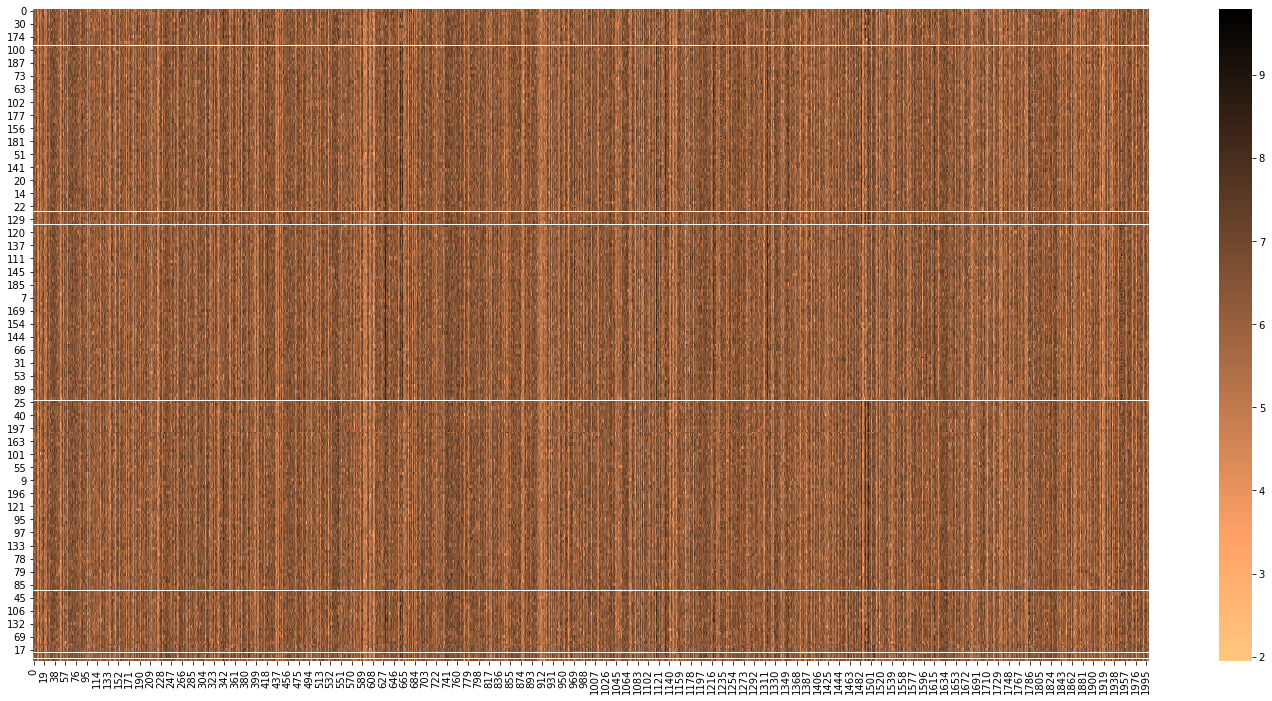

In [26]:
fig, ax = plt.subplots(figsize = (25, 12))
sns.heatmap(dat_df.T[:2001].T, cmap = "copper_r")
x_min, x_max = plt.xlim()
for s in counts_sum:
    ax.hlines(y = s, xmin = x_min, xmax = x_max, color = 'white', lw = 1)

### The heatmap shows that the kmeans can reproduce Watson's results with 8 clusters separated by white lines and each block represents one cluster out of eight.

# 2. Reduce the Dimensionality
### Write a Python function that uses singular value decomposition to find the principal components of the dataset. Plot all 200 cells in 2D expression space using their projections onto the first two principal axes.Was Watson right to expect 8 clusters? Plot the eigenvalues for each component, and justify why we're pretty sure it would be hard to find any other clusters in the dataset. The eigenvalues from a simulated negative control data set, where there were no cell types and no correlations between any of the genes, should factor into the answer.Based on the eigenvector loadings, how many genes appear to influence cell type identity? Explain.

In [27]:
N = dat_log.shape[0]

In [28]:
def calculate_eigenvalue(S, N):
    eigenval = []
    for i in range(N):
        eigenval.append(S[i]**2 / (N-1))
    return eigenval

In [30]:
def PCA(data):
    X_centered_data = data - np.mean(data, axis = 0)
    U, S, W_t = np.linalg.svd(X_centered_data)
    W = W_t.T
    PCs = np.dot(X_centered_data, W)
    return PCs, U, S, W, W_t

In [31]:
PCs, U, S, W, W_t = PCA(dat_log)

Text(0, 0.5, 'PC2')

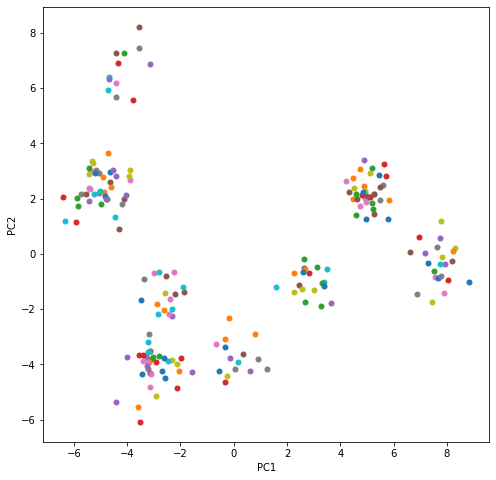

In [32]:
fig2, ax2 = plt.subplots(figsize = (8, 8))
for i in range(N):
    ax2.plot(PCs[:, :2][i, 0], PCs[:, :2][i, 1], '.', ms=10)
    ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

In [33]:
eigenvalues = calculate_eigenvalue(S, N)

Text(0, 0.5, 'Variance Explained')

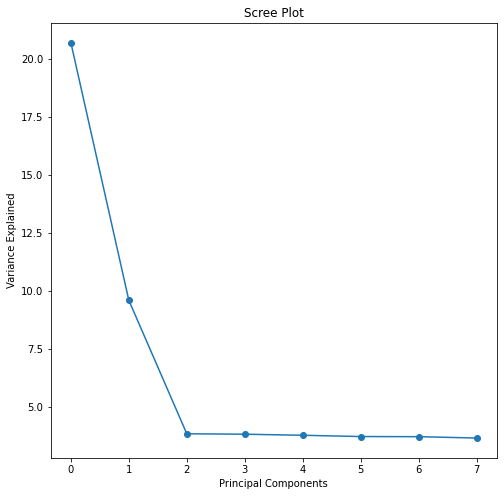

In [34]:
fig3, ax3 = plt.subplots(figsize = (8, 8))
ax3.plot([i for i in range(8)], eigenvalues[:8], 'o-', ms=6)
ax3.set_title("Scree Plot")
ax3.set_xlabel('Principal Components')
ax3.set_ylabel('Variance Explained')

Text(0, 0.5, 'PC2')

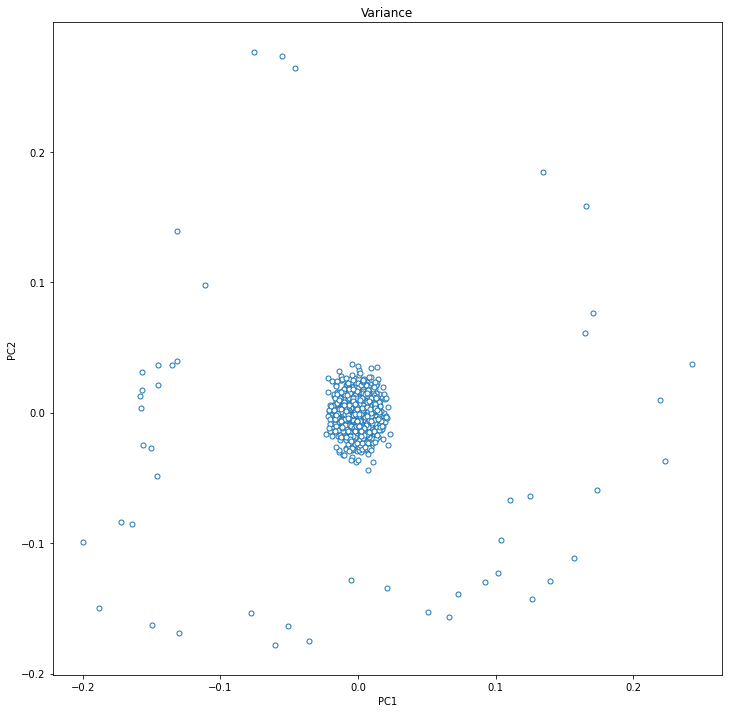

In [35]:
fig4, ax4 = plt.subplots(figsize = (12, 12))
ax4.plot(W[:,:2][:,0], W[:,:2][:,1], 'o', mfc = 'w', ms=5)
ax4.set_title("Variance")
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')

### 

In [36]:
total_variance_PC2 = np.sum(np.dot(np.square(W[:,:2]), np.diag(eigenvalues[0:2])), axis = 1)

Text(0, 0.5, 'Total Variance')

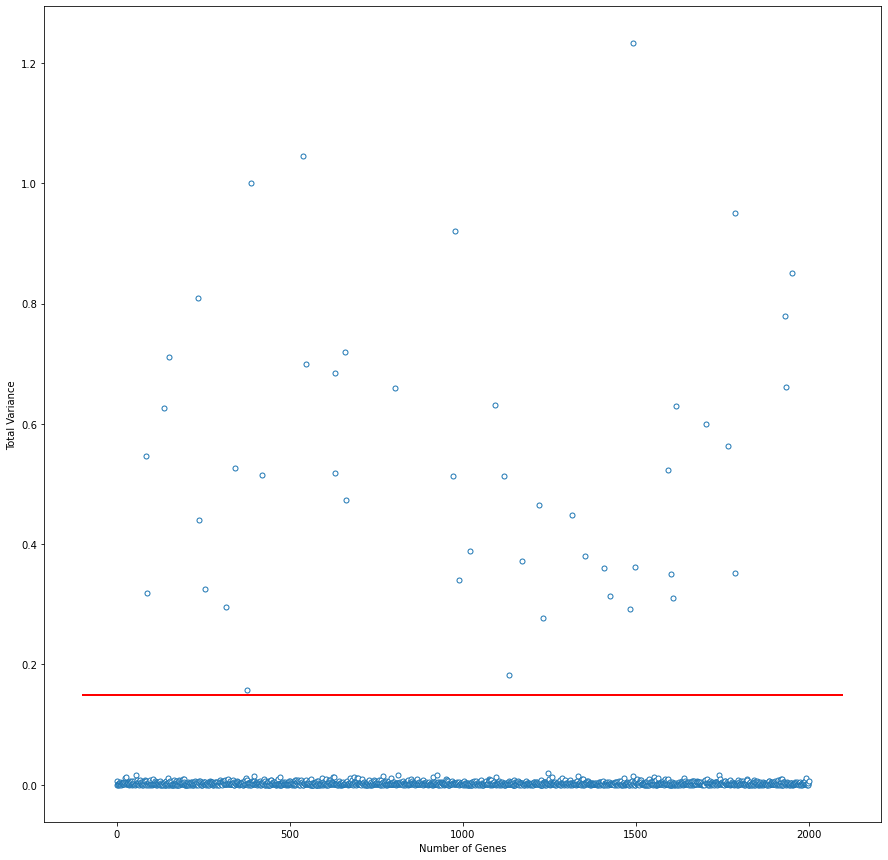

In [37]:
fig5, ax5 = plt.subplots(figsize = (15, 15))
ax5.plot(total_variance_PC2, 'o', mfc = 'w', ms=5)
x_min_5, x_max_5 = plt.xlim()
ax5.hlines(y = 0.15, xmin = x_min_5, xmax = x_max_5, color = 'red', lw = 2)
ax5.set_xlabel('Number of Genes')
ax5.set_ylabel('Total Variance')

In [38]:
significant_genes = [i for i in total_variance_PC2 if i > 0.15]
print("We have %i genes that might influence cell type identity."%len(significant_genes))

We have 47 genes that might influence cell type identity.


### Based on the PCA result and the plots shown above, it is correct to expect seeing 8 clusters. The PC1 vs. PC2 plot correctly shows that the eigenvalues are clustered at 0.0 for a 2D PCA result. The scree plot also shows that the first 2 components captured most of the variances that we can capture using 2D PCA. The final total variance plot also suggests that. Thus, it is unlikely to have more than 8 clusters in this case, and 47 genes appear to influence cell type identity by the total variance in the principal components.

# 3. Check the K
### Plot the data in 2D principal component space, and color each point according to the cluster identities from part 1. Find the K-means that is missing the mark.Offer an explanation of what might be going wrong, and find a way to cluster so that each cell appears properly assigned in PC space.

Text(0, 0.5, 'PC2')

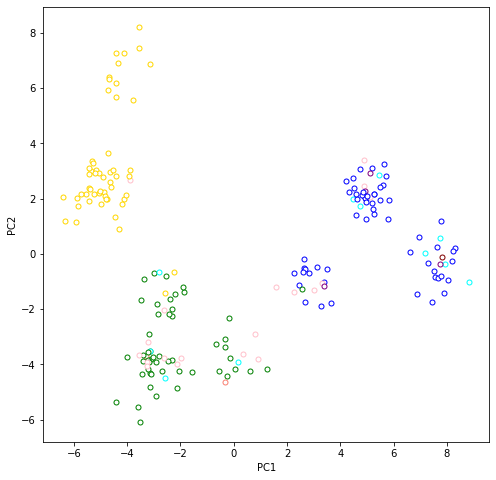

In [39]:
fig2, ax2 = plt.subplots(figsize = (8, 8))
colormap = ['cyan', 'green', 'purple', 'gold', 'blue', 'pink', 'salmon', 'maroon', 'black', 'red']
for i in range(N):
    ax2.plot(PCs[:, :2][i, 0], PCs[:, :2][i, 1], 'o', mec = colormap[assignmnets[i]%8], mfc='w', ms=5)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

In [40]:
K_cluster = 8
num_run = 20

In [41]:
min_sqdist_PCA  = float("inf")
best_run_PCA = float("inf")
for r in range(num_run):
    np.random.seed(r)
    kp_PCA, centroids_PCA, assignments_PCA, total_sqdist_PCA = kmeans(PCs[:, :2], K_cluster)
    if total_sqdist_PCA < min_sqdist_PCA:
        min_sqdist_PCA  = total_sqdist_PCA
        best_run_PCA = r
print("The best run was %i with min sqrd distance of %.2f"%(best_run_PCA, min_sqdist_PCA))

Meeting threshold 0.01 at iteration 2 with 312.01
Meeting threshold 0.01 at iteration 6 with 129.71
Meeting threshold 0.01 at iteration 4 with 386.05
Meeting threshold 0.01 at iteration 9 with 402.53
Meeting threshold 0.01 at iteration 14 with 293.23
Meeting threshold 0.01 at iteration 2 with 206.21
Meeting threshold 0.01 at iteration 6 with 215.51
Meeting threshold 0.01 at iteration 5 with 129.71
Meeting threshold 0.01 at iteration 5 with 129.71
Meeting threshold 0.01 at iteration 3 with 129.71
Meeting threshold 0.01 at iteration 4 with 208.00
Meeting threshold 0.01 at iteration 5 with 208.18
Meeting threshold 0.01 at iteration 9 with 293.84
Meeting threshold 0.01 at iteration 7 with 216.86
Meeting threshold 0.01 at iteration 14 with 300.64
Meeting threshold 0.01 at iteration 4 with 215.32
Meeting threshold 0.01 at iteration 6 with 129.71
Meeting threshold 0.01 at iteration 6 with 129.71
Meeting threshold 0.01 at iteration 6 with 202.85
Meeting threshold 0.01 at iteration 5 with 129.7

In [42]:
np.random.seed(16)
kp_PCA, centroids_PCA, assignments_PCA, total_sqdist_PCA = kmeans(PCs[:, :2], K_cluster)

Meeting threshold 0.01 at iteration 6 with 129.71


Text(0.5, 1.0, 'K-means using PCA')

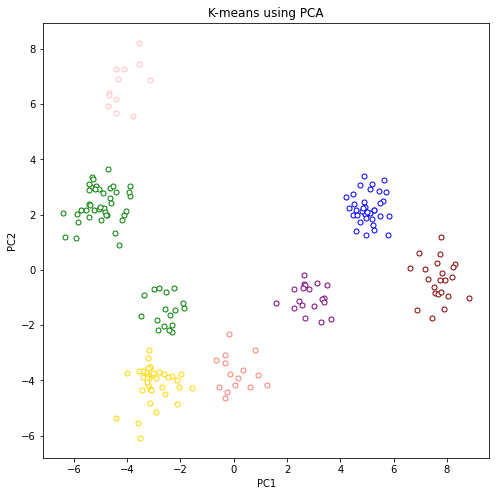

In [43]:
fig6, ax6 = plt.subplots(figsize = (8, 8))
colormap = ['cyan', 'green', 'purple', 'gold', 'blue', 'pink', 'salmon', 'maroon', 'black', 'red']
for i in range(N):
    ax6.plot(PCs[:, :2][i, 0], PCs[:, :2][i, 1], 'o', mec = colormap[assignments_PCA[i]%7+1], mfc='w', ms=5)
ax6.set_xlabel("PC1")
ax6.set_ylabel("PC2")
ax6.set_title("K-means using PCA")

#### The first plot of PC1 vs. PC2, it shows that there is too much noise sneaked in the K-means clustering of the data with 2001 dimensions. From the previous part, we know that there are 47 genes have an impact on cell type identity among the 2001 genes in total, meaning that other genes might be the noise and lead to the unclear clustering. Based on the second plot of PC1 vs. PC2, the result shows that PCA using K-means can decrease the noise and gives a better clustering result.

# 4. Reconstruct the Expression Patterns
### Reconstruct the original dataset using only the projected data and eigenvectors for the first 2 principal components. Visualize the data using a heat map. Do the clusters now look more obvious? Why or why not?

In [44]:
new_eigenvectors = U[:, :2] @ np.diag(S[:2]) @ W_t[:2, :]
new_eigenvectors_df = pd.DataFrame(new_eigenvectors)
new_eigenvectors_df["cluster"] = assignments_PCA
new_eigenvectors_df = new_eigenvectors_df.sort_values('cluster')
new_eigenvectors_df

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,2000,cluster
139,0.090628,0.012631,0.048336,0.047913,-0.011614,0.005438,0.045746,0.045659,0.066995,-0.026167,...,0.147247,0.027497,-0.027759,0.009954,0.046407,0.031560,-0.007101,0.071879,-0.018830,0
111,0.090416,0.012113,0.042194,0.041560,-0.010030,0.003094,0.048065,0.041479,0.058775,-0.030066,...,0.137067,0.027727,-0.029654,0.008244,0.041199,0.025644,-0.006859,0.064247,-0.006168,0
31,0.088355,0.012118,0.044694,0.044196,-0.010695,0.004362,0.045576,0.042873,0.062065,-0.027107,...,0.139590,0.026926,-0.027852,0.009025,0.043188,0.028414,-0.006832,0.067068,-0.013273,0
108,0.114136,0.014903,0.048478,0.047510,-0.011425,0.002055,0.062599,0.049129,0.067796,-0.041096,...,0.165220,0.035233,-0.038989,0.009069,0.047960,0.027735,-0.008480,0.075178,0.002227,0
169,0.091041,0.012500,0.046226,0.045718,-0.011065,0.004562,0.046892,0.044293,0.064183,-0.027817,...,0.144116,0.027736,-0.028643,0.009347,0.044647,0.029445,-0.007046,0.069321,-0.014038,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.011970,0.000539,0.020841,0.021851,-0.005497,0.009811,-0.016993,0.012359,0.027557,0.021336,...,0.024961,-0.004957,0.012518,0.006298,0.016896,0.022209,-0.000079,0.024207,-0.054485,7
84,-0.028269,-0.000932,0.022028,0.023461,-0.005960,0.012654,-0.029194,0.010822,0.028720,0.032530,...,0.014596,-0.010383,0.020722,0.007271,0.016906,0.026106,0.000830,0.023510,-0.071775,7
65,-0.013509,0.000116,0.017457,0.018385,-0.004638,0.008727,-0.016739,0.009853,0.022992,0.020097,...,0.018280,-0.005299,0.012156,0.005412,0.013940,0.019190,0.000138,0.019814,-0.048802,7
109,-0.008841,0.000616,0.018085,0.018926,-0.004755,0.008287,-0.013634,0.010947,0.023953,0.017527,...,0.022827,-0.003792,0.010121,0.005404,0.014756,0.019012,-0.000159,0.021211,-0.045876,7


In [45]:
unique_cluster, counts = np.unique(new_eigenvectors_df.cluster, return_counts = True)
print(counts)
cumulative_sum_pca = np.cumsum(counts)
cumulative_sum_pca

[41 19 37 37 12 15 22 17]


array([ 41,  60,  97, 134, 146, 161, 183, 200])

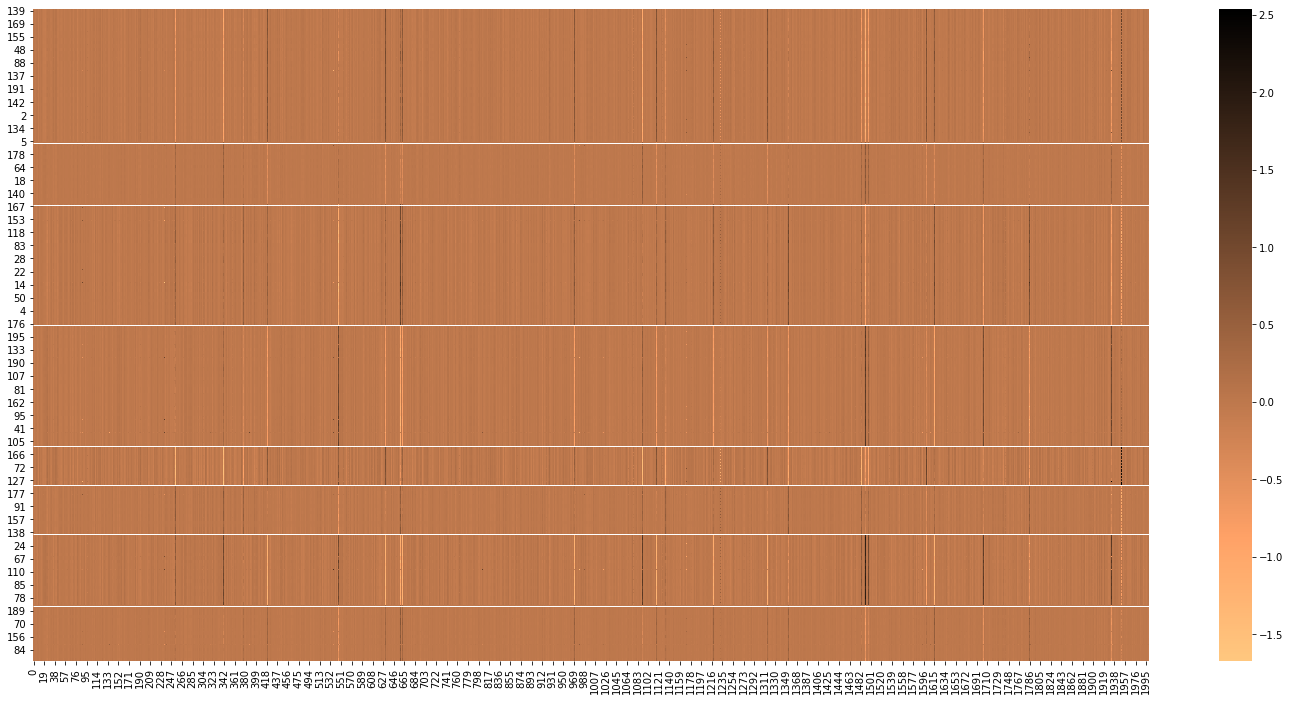

In [47]:
fig, ax = plt.subplots(figsize = (25, 12))
sns.heatmap(new_eigenvectors_df.T[:2001].T, cmap = "copper_r")
x_min, x_max = plt.xlim()
for s in cumulative_sum_pca:
    ax.hlines(y = s, xmin = x_min, xmax = x_max, color = 'white', lw = 1)

### Compared to the previous plotted heatmap, it is definitely more obvious to see the 8 clusters separated by white lines. For the significant contributor genes, each of them have a different expression within clusters. Other genes that are considered non-significant, their corresponding eigenvectors are all about 0. 